In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import required libraries
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
from plotutils import plot_data, plot_surface
from SVM import kernel_svm_train, kernel_svm_predict
from Multiclass_SVM import fit, predict
from sklearn import preprocessing
from crossval import cross_validate
import matplotlib
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

In [3]:
# Read the data using pandas
df = pd.read_csv('digit-recognition/digit-recognition/train.csv')
df2 = pd.read_csv('digit-recognition/digit-recognition/test.csv')

#turn the training dataframe into numpy array 
label_data_train = df.to_numpy()

#column vector for the labels (38000,)
label_train = label_data_train[:,0] 

# (38000 x 784 matrix for the training data )
data_train = label_data_train[:, 1:] 

# Turn testing dataframe into numpy array 
label_data_test = df2.to_numpy()
label_test = label_data_test[:,0]
data_test = label_data_test[:,1:]

In [4]:
# Determine our dataset size for cross validation and training
num_cv_splits = 50
num_train_splits = int(num_cv_splits/2)

# Initialize variables here for convenient use throughout
num_labels = len(np.unique(label_train))
c_vals = 10 ** np.linspace(-2, 1, 4)
orders = [5, 6, 7, 8]
num_folds = 2

CV Subset selection: 5


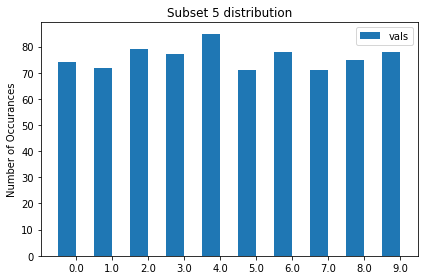

In [5]:
# We won't cross validation on the whole data set to save time. 
# Pick our subset by choosing the split with the most equal label distribution.

frequencies = np.zeros((num_cv_splits, num_labels, 2))
split_train_labels = np.split(label_train, num_cv_splits)

for i in range(len(split_train_labels)):
    (unique, counts) = np.unique(split_train_labels[i], return_counts=True)
    frequencies[i] = np.asarray((unique, counts)).T
    
variances = np.zeros(len(frequencies))

for i in range(len(frequencies)):
    labels = frequencies[i][:, 0]
    vals = frequencies[i][:, 1]
    variances[i] = np.var(vals)
    
cv_subset_selection = np.argmin(variances)
print("CV Subset selection: {0}".format(cv_subset_selection))

labels = frequencies[cv_subset_selection][:, 0]
vals = frequencies[cv_subset_selection][:, 1]

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.25, vals, 0.5, label='vals')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Occurances')
ax.set_title('Subset {0} distribution'.format(cv_subset_selection))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Training subset selection: 3


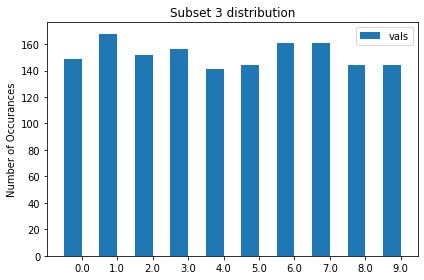

In [6]:
# We won't train on the whole data set either but will get a data subset larger than the CV subset. 
# Pick our subset by choosing the split with the most equal label distribution.

frequencies = np.zeros((num_train_splits, num_labels, 2))
split_train_labels = np.split(label_train, num_train_splits)

for i in range(len(split_train_labels)):
    (unique, counts) = np.unique(split_train_labels[i], return_counts=True)
    frequencies[i] = np.asarray((unique, counts)).T
    
variances = np.zeros(len(frequencies))

for i in range(len(frequencies)):
    labels = frequencies[i][:, 0]
    vals = frequencies[i][:, 1]
    variances[i] = np.var(vals)
    
training_subset_selection = np.argmin(variances)
print("Training subset selection: {0}".format(training_subset_selection))

labels = frequencies[training_subset_selection][:, 0]
vals = frequencies[training_subset_selection][:, 1]

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.25, vals, 0.5, label='vals')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Occurances')
ax.set_title('Subset {0} distribution'.format(training_subset_selection))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [7]:
#Split the data set based on the subset selections above 

split_cv_data = np.split(data_train, num_cv_splits)[cv_subset_selection]
split_cv_labels = np.split(label_train, num_cv_splits)[cv_subset_selection]

split_train_data = np.split(data_train, num_train_splits)[training_subset_selection]
split_train_labels = np.split(label_train, num_train_splits)[training_subset_selection]

In [8]:
# Run cross validation on polynomial kernel to determine best parameters

best_params = []
best_score = 0

for j in range(len(c_vals)):
    for k in range(len(orders)):
        params = {
            'kernel': 'polynomial',
            'C': c_vals[j],
            'order': orders[k]
        }

        cv_score, _ = cross_validate(fit, predict, split_cv_data, split_cv_labels, num_folds, params)
        if cv_score > best_score:
            best_score = cv_score
            best_params = params
print("Determined best parameters for Polynomial Kernel: {0}".format(best_params))

Determined best parameters for Polynomial Kernel: {'kernel': 'polynomial', 'C': 0.01, 'order': 7}


In [9]:
# Run polynomial kernel with the selected parameters

model = fit(split_train_data, split_train_labels, best_params, True)
predictions = predict(data_test.T, model)

test_accuracy = np.mean(predictions == label_test)
print("Test accuracy: {0} %".format(test_accuracy*100))

Finished fitting binary model 0
Finished fitting binary model 1
Finished fitting binary model 2
Finished fitting binary model 3
Finished fitting binary model 4
Finished fitting binary model 5
Finished fitting binary model 6
Finished fitting binary model 7
Finished fitting binary model 8
Finished fitting binary model 9
Test accuracy: 93.575 %


In [10]:
# Run cross validation on linear kernel to determine best parameters

best_params = []
best_score = 0

for j in range(len(c_vals)):
    params = {
        'kernel': 'linear',
        'C': c_vals[j],
    }

    cv_score, _ = cross_validate(fit, predict, split_cv_data, split_cv_labels, num_folds, params)
    if cv_score > best_score:
        best_score = cv_score
        best_params = params
print("Determined best parameters for Linear Kernel: {0}".format(best_params))

Determined best parameters for Linear Kernel: {'kernel': 'linear', 'C': 0.01}


In [11]:
# Run linear kernel with the selected parameters

model = fit(split_train_data, split_train_labels, best_params, True)
predictions = predict(data_test.T, model)

test_accuracy = np.mean(predictions == label_test)
print("Test accuracy: {0} %".format(test_accuracy*100))

Finished fitting binary model 0
Finished fitting binary model 1
Finished fitting binary model 2
Finished fitting binary model 3
Finished fitting binary model 4
Finished fitting binary model 5
Finished fitting binary model 6
Finished fitting binary model 7
Finished fitting binary model 8
Finished fitting binary model 9
Test accuracy: 75.47500000000001 %


<AxesSubplot:>

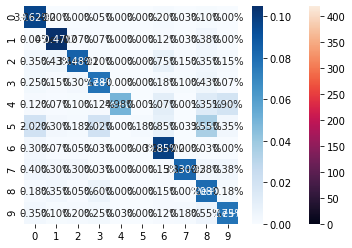

In [12]:
#Confusion Matrix
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
#code to create a confusion matrix using scikit-learn and seaborn 
cf_matrix = confusion_matrix(label_test, predictions)
sns.heatmap(cf_matrix, annot=True)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [13]:
#F-score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
#computation of the f1_score using sci-kit learn 
#F1 makes more sense as want to maximize number of correct scores (care more about precision than recall for application)
#F2 cares more about correctly classifying (which is beneficial in other application)
#Getting an error of some sort 
f1_score(label_test, predictions, average='macro')
f1_score(label_test, predictions, average='micro')
f1_score(label_test, predictions, average='weighted')

0.7203697344459087

In [14]:
#Maybe try ROC? 